# load data

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """
    加载预处理的手势数据，并拆分为训练集和测试集。
    
    参数：
    root_path (str): 存储 processed_gesture_data.npy 和 gesture_labels.npy 的根目录
    test_size (float): 测试集比例，默认 20%
    random_state (int): 随机种子，确保可复现性
    
    返回：
    X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
    """
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path,allow_pickle=True)
    y = np.load(label_path,allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

data_folder = r"new_collect\fzh"  
X_train, X_test, y_train, y_test = load_data(data_folder)


Loading processed data...
Data shape: (574, 19, 100, 10), Labels shape: (574,)
Training set: (459, 19, 100, 10), Testing set: (115, 19, 100, 10)


In [2]:
import random

import numpy as np

def shift_data(X, shift_steps=5, direction="right"):
    """
    对时序数据进行平移（Shift Data）

    参数：
    - X: np.array, 形状 (samples, timesteps, features)，EMG/IMU 时序数据
    - shift_steps: int, 平移的步数（时间步）
    - direction: str, "right"（向前）或 "left"（向后）

    返回：
    - X_shifted: np.array, 形状 (samples, timesteps, features)，平移后的数据
    """
    X_shifted = np.zeros_like(X)

    if direction == "right":
        X_shifted[:, shift_steps:, :] = X[:, :-shift_steps, :]
    elif direction == "left":
        X_shifted[:, :-shift_steps, :] = X[:, shift_steps:, :]
    else:
        raise ValueError("direction must be 'right' or 'left'.")

    return X_shifted

def augment_shifted_data(X, num_versions=5, max_shift=10):
    """
    创建多个不同 shift 版本的数据集（数据增强）

    参数：
    - X: np.array, 形状 (samples, timesteps, features)，原始数据
    - num_versions: int, 生成不同 shift 版本的数量
    - max_shift: int, 最大 shift 范围（随机 1~max_shift）

    返回：
    - X_augmented: np.array, 形状 (samples * num_versions, timesteps, features)
    """
    X_augmented = []
    
    for _ in range(num_versions):
        shift_steps = random.randint(1, max_shift)  # 随机 shift 1~max_shift
        direction = random.choice(["right", "left"])  # 随机左移或右移
        X_shifted = shift_data(X, shift_steps, direction)
        X_augmented.append(X_shifted)
    
    return np.concatenate(X_augmented, axis=0)

X_train = augment_shifted_data(X_train, num_versions=3, max_shift=10)
y_train = np.tile(y_train, 3)  # 复制标签

X_test = augment_shifted_data(X_test, num_versions=3, max_shift=10)
y_test = np.tile(y_test, 3)  # 复制标签


# load selected data

In [2]:
# import os
# import numpy as np
# from sklearn.model_selection import train_test_split

# def load_data(root_path, selected_labels=None, test_size=0.2, random_state=42):
#     """
#     加载预处理的手势数据，并拆分为训练集和测试集，支持选择特定的标签。
    
#     参数：
#     - root_path (str): 存储 `processed_gesture_data.npy` 和 `gesture_labels.npy` 的根目录
#     - selected_labels (list[int] or None): 选择加载的标签列表，例如 [1, 4, 6, 7]。如果 None，则加载所有数据。
#     - test_size (float): 测试集比例，默认 20%
#     - random_state (int): 随机种子，确保可复现性
    
#     返回：
#     - X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
#     """
#     data_path = os.path.join(root_path, "processed_gesture_data.npy")
#     label_path = os.path.join(root_path, "gesture_labels.npy")
    
#     if not os.path.exists(data_path) or not os.path.exists(label_path):
#         raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
#     print("Loading processed data...")
#     X = np.load(data_path, allow_pickle=True)
#     y = np.load(label_path, allow_pickle=True)
    
#     print(f"Original Data shape: {X.shape}, Labels shape: {y.shape}")

#     # 选择指定标签的数据
#     if selected_labels is not None:
#         selected_labels = set(selected_labels)  # 转换为集合加速查询
#         mask = np.isin(y, list(selected_labels))  # 选择符合标签的数据
#         X = X[mask]
#         y = y[mask]
#         print(f"Filtered Data shape (after selecting labels {selected_labels}): {X.shape}")

#     # 划分训练集和测试集
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=random_state, stratify=y
#     )

#     print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
#     return X_train, X_test, y_train, y_test

# # 示例调用：加载所有数据
# data_folder = r"new_collect\fzh"
# X_train, X_test, y_train, y_test = load_data(data_folder)

# # 示例调用：只加载选定的标签
# selected_labels = [1, 4, 6, 7]
# X_train, X_test, y_train, y_test = load_data(data_folder, selected_labels=selected_labels)


Loading processed data...
Original Data shape: (325, 19, 100, 10), Labels shape: (325,)
Training set: (260, 19, 100, 10), Testing set: (65, 19, 100, 10)
Loading processed data...
Original Data shape: (325, 19, 100, 10), Labels shape: (325,)
Filtered Data shape (after selecting labels {1, 4, 6, 7}): (100, 19, 100, 10)
Training set: (80, 19, 100, 10), Testing set: (20, 19, 100, 10)


# cnn

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D

X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan = 0.0)
y_test = np.nan_to_num(y_test, nan = 0.0)
# **获取数据形状**
num_batches = X_train.shape[0]  # batch 维度
num_windows = X_train.shape[1]  # 时间步（窗口数 59）
num_features = X_train.shape[2]  # 特征数（15）
num_channels = X_train.shape[3]  # 通道数（1）

# **检测类别数量**
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)  # 确保类别数正确

print(f"Corrected Classes: {num_classes}, Batches: {num_batches}, Windows: {num_windows}, Features: {num_features}, Channels: {num_channels}")

# **保持 X 形状**
X_train = X_train.reshape(num_batches, num_windows, num_features, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_windows, num_features, num_channels)
X_train = X_train[:,:,:,:]
X_test = X_test[:,:,:,:]

# print(X_train.shape)

num_features = X_train.shape[2] 
num_channels = X_train.shape[3]
# **标签编码**
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # 转换成 0,1,2
y_test = encoder.transform(y_test)

# **转换为 One-Hot**
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # (batch, 59, 15, 1) (batch, 3)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # (batch, 59, 15, 1) (batch, 3)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (batch_size, 29, 40)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)  

# # print(num_features)
# # **构建 LSTM 处理通道的模型**

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(num_windows, num_features * num_channels)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # 多分类输出
])

from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # 每 10 个 epoch，学习率减半
    return lr

# **编译模型**
model.compile(
    optimizer=Adam(learning_rate=0.001),  # 初始学习率
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **使用回调函数**
lr_callback = LearningRateScheduler(lr_schedule)

# **训练时加上 callback**
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))


# **测试模型**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# **保存模型**
model.save("cnn_emg_model.h5")
print("Model saved as cnn_emg_model.h5")


Corrected Classes: 23, Batches: 1377, Windows: 19, Features: 100, Channels: 10
X_train shape: (1377, 19, 100, 10), y_train shape: (1377, 23)
X_test shape: (345, 19, 100, 10), y_test shape: (345, 23)
Epoch 1/100
44/44 [==============================] - 6s 38ms/step - loss: 3.3927 - accuracy: 0.0821 - val_loss: 3.0423 - val_accuracy: 0.0812 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 1s 22ms/step - loss: 2.8964 - accuracy: 0.1394 - val_loss: 2.7863 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 1s 21ms/step - loss: 2.6260 - accuracy: 0.1954 - val_loss: 2.3950 - val_accuracy: 0.2464 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 2.3567 - accuracy: 0.2542 - val_loss: 1.8969 - val_accuracy: 0.3623 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 1s 23ms/step - loss: 2.1406 - accuracy: 0.2941 - val_loss: 1.4929 - val_accuracy: 0.5072 - lr: 0.0010
Epoch 6/100
44/44 [=======

In [17]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))
model.save("cnn_emg_model.h5")
print("Model saved as rnn_emg_model.h5")

Epoch 1/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0714 - accuracy: 0.9695 - val_loss: 0.0405 - val_accuracy: 0.9826 - lr: 3.8742e-04
Epoch 2/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0502 - accuracy: 0.9826 - val_loss: 0.2020 - val_accuracy: 0.9478 - lr: 3.8742e-04
Epoch 3/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0869 - accuracy: 0.9717 - val_loss: 0.0750 - val_accuracy: 0.9826 - lr: 3.8742e-04
Epoch 4/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0889 - accuracy: 0.9760 - val_loss: 0.0507 - val_accuracy: 0.9826 - lr: 3.8742e-04
Epoch 5/100
15/15 [==============================] - 1s 57ms/step - loss: 0.0617 - accuracy: 0.9782 - val_loss: 0.0215 - val_accuracy: 0.9913 - lr: 3.8742e-04
Epoch 6/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0506 - accuracy: 0.9782 - val_loss: 0.0097 - val_accuracy: 0.9913 - lr: 3.8742e-04
Epoch 7/100
15/15 [===========================

# confusion matrix

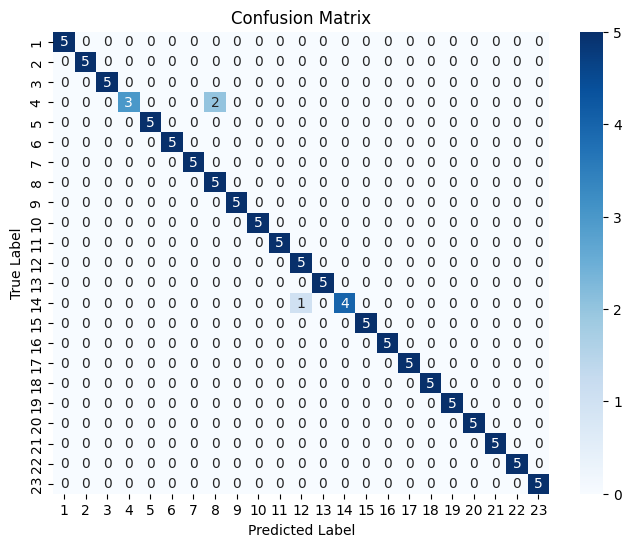

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# history graph

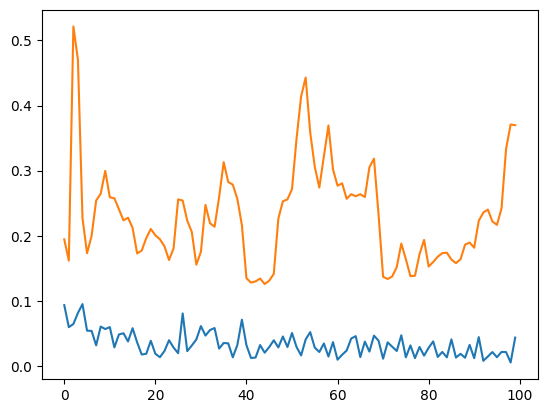

In [14]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 19, 64)            192064    
                                                                 
 batch_normalization_12 (Bat  (None, 19, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 9, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 9, 128)            24704     
                                                                 
 batch_normalization_13 (Bat  (None, 9, 128)           512       
 chNormalization)                                                
                                                      